In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [3]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


########### Updated list using the color-LogWimx correaltion


In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

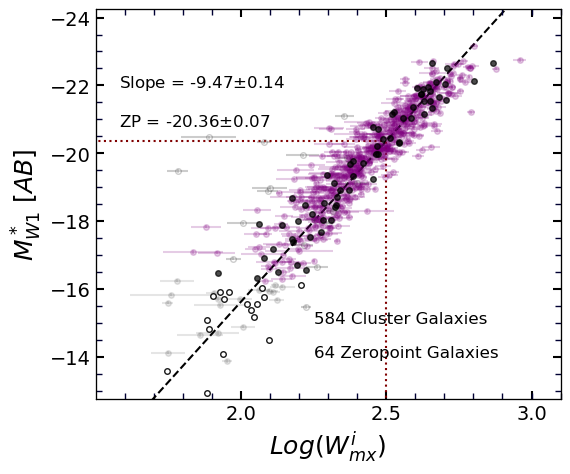

In [5]:
band = 'w1'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=True,
                                            getZPcalib=True)

In [6]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[-9.472804095041074 0.1420617834915643 -20.355967164653094
 array([0.0737759])]


In [7]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -9.472804095041074 12.810707011891411 33.052202806114266 Pegasus
NEST_200037 -9.472804095041074 14.167951399102137 34.576347544388256 NGC70
NEST_200017 -9.472804095041074 14.8597641479123 35.12850938235033 Abell 539
NEST_200005 -9.472804095041074 13.605089709444934 33.95207116179037 NGC410
NEST_200006 -9.472804095041074 13.637350856372592 33.96949772605892 NGC507
NEST_100014 -9.472804095041074 12.422628412585503 32.781621723304966 Antlia
NEST_200003 -9.472804095041074 13.491610217354387 33.82304870298028 Abell 262
NEST_100001 -9.472804095041074 14.495212360703794 34.84791521246897 Coma
NEST_100003 -9.472804095041074 12.276647284627721 32.62728561322557 Centaurus
NEST_100002 -9.472804095041074 10.44184271842572 30.888497832434254 Virgo
NEST_100005 -9.472804095041074 14.492125533696063 34.845542520850046 Abell 1367
NEST_200045 -9.472804095041074 14.089801186891595 34.442030955225434 NGC80
NEST_100007 -9.472804095041074 15.685319136161965 36.031427095340604 Abell 2151 (Hercule

In [8]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (24) -8.64 0.53 10.53 0.11 10.44 0.10 0.82


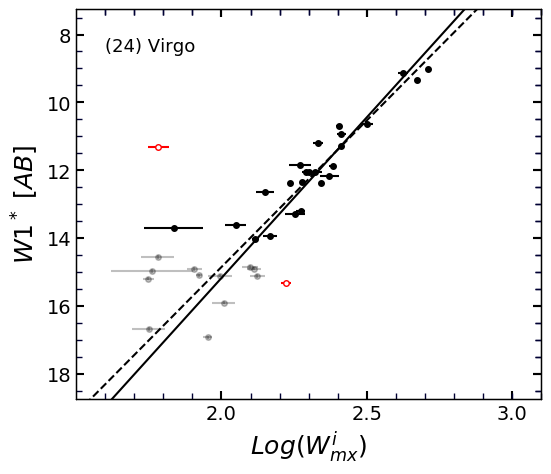

In [9]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(2, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')   
        x_ax.set_xticks(np.arange(2, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (24) -8.64 0.53 10.53 0.11 10.44 0.10 0.82
Ursa Major (36) -9.94 0.49 10.77 0.08 10.80 0.08 0.59
Fornax (17) -8.86 0.61 10.88 0.13 10.86 0.14 0.79
Centaurus (22) -10.44 1.40 12.27 0.15 12.28 0.13 0.59
Antlia (17) -9.80 1.05 12.43 0.12 12.42 0.11 0.61
Pegasus (23) -10.19 1.21 12.70 0.24 12.81 0.12 0.66
Hydra (44) -8.29 0.55 13.27 0.09 13.31 0.10 0.79
Abell 262 (54) -7.86 0.63 13.47 0.11 13.49 0.13 0.98
NGC410 (31) -9.93 0.83 13.60 0.11 13.61 0.10 0.64
NGC507 (22) -8.78 0.52 13.61 0.08 13.64 0.08 0.38
Cancer (17) -9.95 0.84 13.80 0.12 13.79 0.11 0.51
NGC80 (13) -9.68 1.23 14.09 0.13 14.09 0.12 0.53
NGC70 (11) -10.23 1.40 14.22 0.16 14.17 0.12 0.42
Abell 1367 (62) -9.70 0.52 14.49 0.06 14.49 0.06 0.59
Coma (75) -10.21 0.48 14.49 0.07 14.50 0.06 0.62
Abell 400 (23) -10.19 0.76 14.55 0.09 14.54 0.08 0.69
NGC4065 (12) -10.21 0.87 14.68 0.12 14.71 0.11 0.53
Abell 539 (22) -8.28 0.66 14.77 0.08 14.86 0.08 0.39
Abell 2634/66 (26) -9.91 0.92 14.97 0.12 14.93 0.08 0.57
Abell 2151 (Hercules)

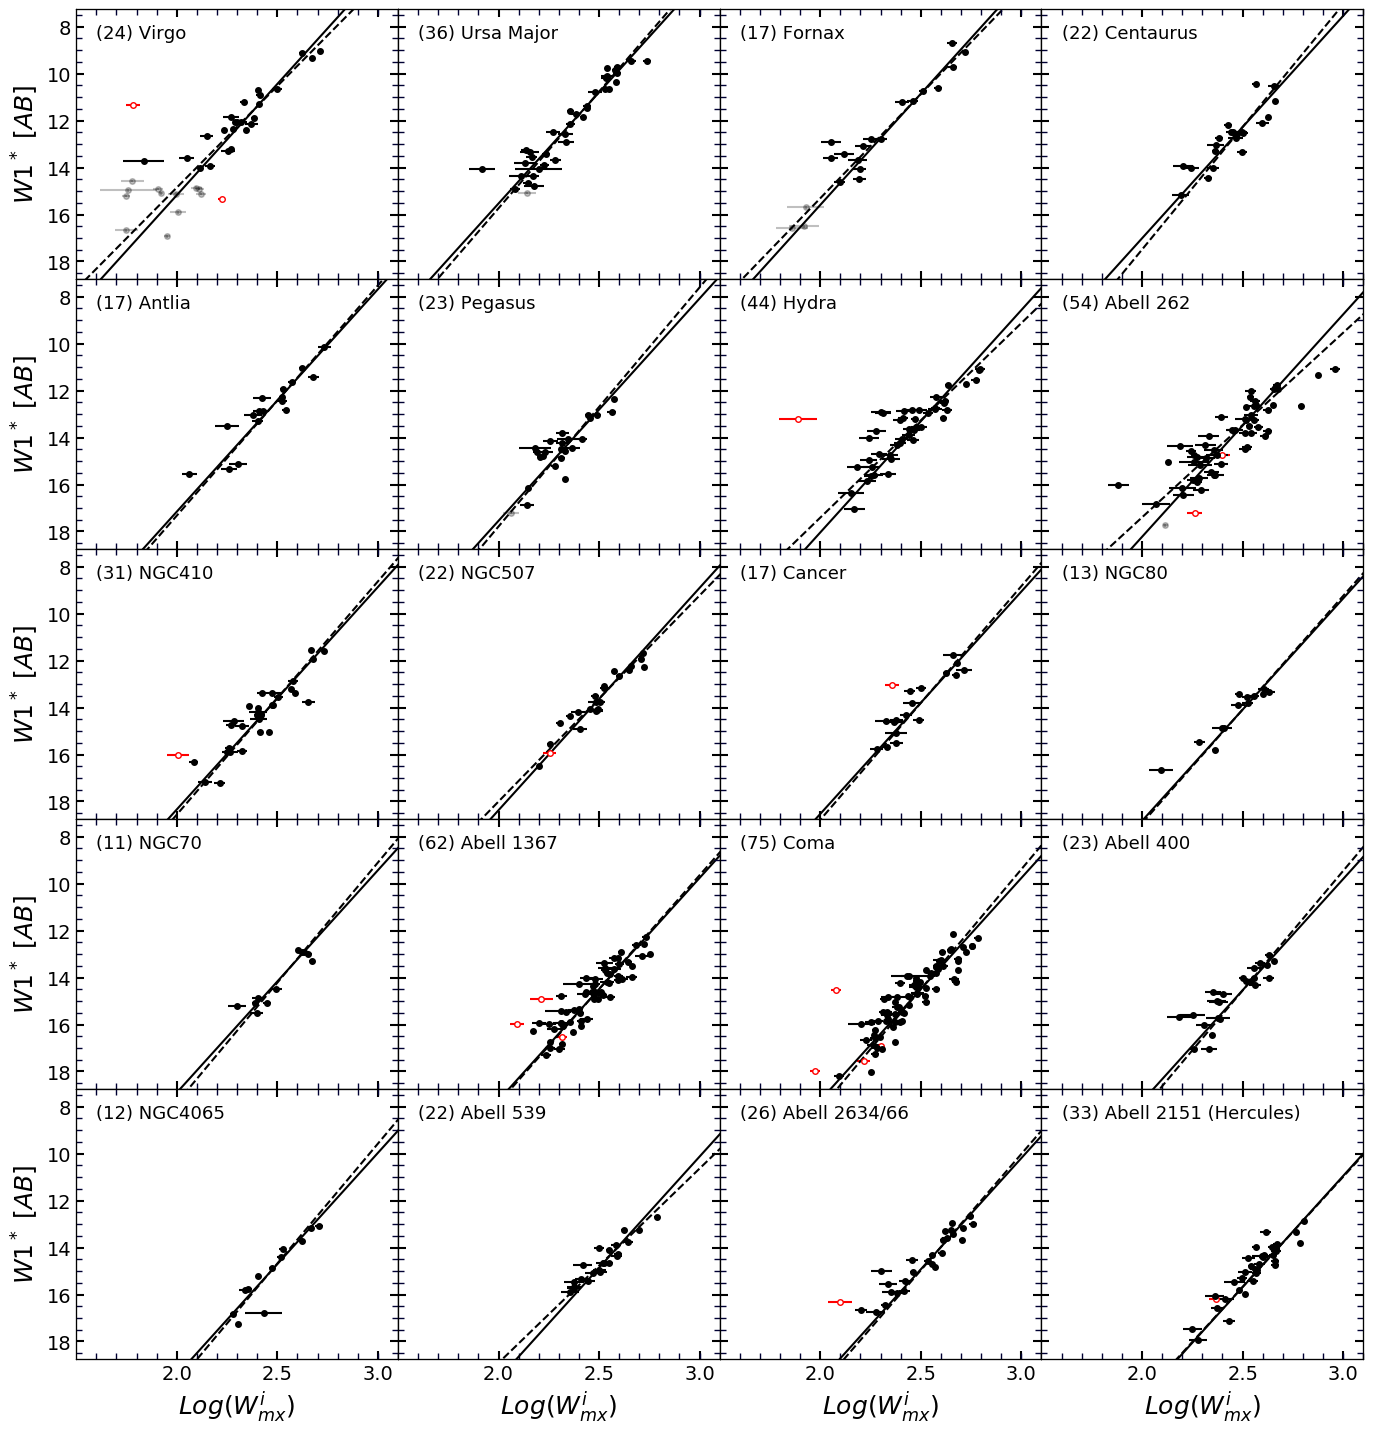

In [10]:
fig = py.figure(figsize=(13.99, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 4); p=0


for i in indx:
    key = keys[i]
    ax = plt.subplot(gs[p])
    plotSingleCluster(key)
    
    if p%4==0: 
        ax.set_ylabel(r'$'+band.upper()+'^* \/\/ [AB]$', fontsize=18)
    else:
        plt.setp(ax.get_yticklabels(), visible=False) 
        
    if p>15: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [11]:
# symcol = {}
# symcol['V']  = 'black'
# symcol['U']  = 'blue'
# symcol['F']  = 'green'
# symcol['Ce'] = 'dodgerblue'
# symcol['An'] = 'olive'
# symcol['Pe'] = 'darkgreen'
# symcol['Hy'] = 'm'
# symcol['A2'] = 'darkgoldenrod'
# symcol['N41'] = 'orchid'
# symcol['N5'] = 'firebrick'
# symcol['Ca'] = 'sienna'
# symcol['N8'] = 'slateblue'
# symcol['N7'] = 'chocolate'
# symcol['A1'] = 'red'
# symcol['Co'] = 'maroon'
# symcol['A4'] = 'deeppink'
# symcol['N40']= 'magenta'
# symcol['A5'] = 'crimson'
# symcol['A26'] = 'purple'
# symcol['He'] = 'indigo'

symcol = {}
symcol['NEST_100002']=['Virgo', '*', 'black']
symcol['NEST_100008']=['UMa', '^', 'blue']
symcol['NEST_200015']=['Fornax', 's', 'green']
symcol['NEST_100003']=['Centaurus', 'D', 'dodgerblue']
symcol['NEST_100014']=['Antlia', '.', 'olive']
symcol['NEST_200092']=['Pegasus', '*', 'darkgreen']
symcol['NEST_100006']=['Hydra', '^', 'm']
symcol['NEST_200003']=['A262', 's', 'darkgoldenrod']
symcol['NEST_200005']=['N410', '*', 'orchid']
symcol['NEST_200006']=['N507', '.', 'firebrick']
symcol['NEST_100030']=['Cancer', '.', 'sienna']
symcol['NEST_200045']=['N80', '*', 'slateblue']
symcol['NEST_200037']=['N70', '.', 'chocolate']
symcol['NEST_100005']=['A1367', 's', 'red']
symcol['NEST_100001']=['Coma', '*', 'maroon']
symcol['NEST_200012']=['A400', 'D', 'deeppink']
symcol['NEST_100018']=['N4065', '*', 'magenta']
symcol['NEST_200017']=['A539', 's', 'crimson']
symcol['NEST_200016']=['A2634/66', '^', 'purple']
symcol['NEST_100007']=['Hercules', 'D', 'indigo']
def getVmod(key):

    if key == 'NEST_100002':  # Virgo
        return 1516., 45.
    if key == 'NEST_100008':  # U Ma
        return 1141., 13.
    if key == 'NEST_200015':  # Fornax
        return 1383., 32. 
    if key == 'NEST_200092':  # Pegasus
        return 3249., 61.
    if key == 'NEST_100003':  # Centaurus
        return 3645., 56.    
    if key == 'NEST_100014':  # Antlia
        return 3103., 53.
    if key == 'NEST_100006':  # Hydra
        return 4084., 44.    
    if key == 'NEST_200003':  # A 262
        return 4684., 50.
    if key == 'NEST_200006':  # N 507
        return 4660., 64.      
    if key == 'NEST_200005':  # N 410
        return 4792., 53.
    if key == 'NEST_100030':  # Cancer
        return 5025., 71.    
    if key == 'NEST_200045':  # N 80
        return 5499., 42. 
    if key == 'NEST_200037':  # N 70
        return 6619., 80.     
    if key == 'NEST_100005':  # A 1367
        return 7060., 61.    
    if key == 'NEST_100001':  # Coma
        return 7352., 70.
    if key == 'NEST_200012':  # A 400
        return 7357., 85. 
    if key == 'NEST_100018':  # N 4065
        return 7501., 63.
    if key == 'NEST_200017':  # A 539
        return 8995., 87.
    if key == 'NEST_200016':  # A 2634/66
        return 8954., 98.
    if key == 'NEST_100007':  # Hercules
        return 11353., 121.      

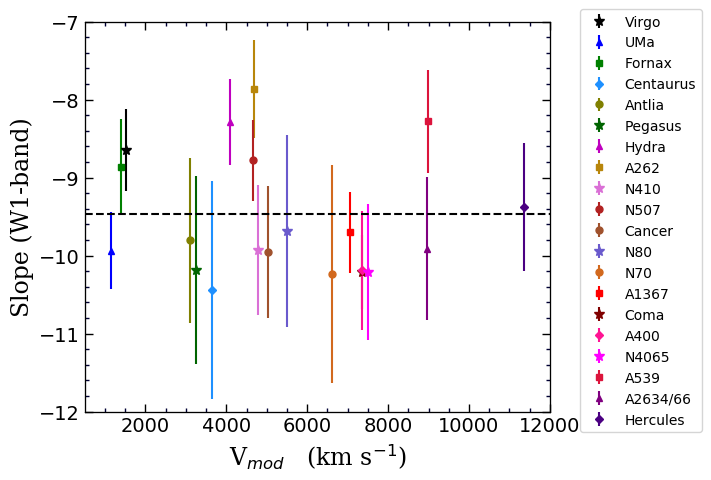

In [12]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
    
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


for i in indx:
    key = keys[i]
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    name = Clusters_orig[key]['name']
    code = Clusters_orig[key]['code']
    Vmod, Vmod_e = getVmod(key)
#     print name, Sorig, Sorig_e, Vmod, Vmod_e
    if Sorig!=0:
        
        
        if symcol[key][1]=='*':
                size = 7
        elif symcol[key][1]=='D':
                size = 4    
        elif symcol[key][1]=='s':
                size = 4           
        elif symcol[key][1]=='^':
                size = 5   
        elif symcol[key][1]=='.':
                size = 10          
        
        
        
        ax.errorbar(Vmod, Sorig, yerr=Sorig_e, fmt=symcol[key][1], color=symcol[key][2], ms=size, label=symcol[key][0])


        

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
        
ax.set_xlabel('V'+r'$_{mod}$'+'   (km s'+r'$^{-1}$'+')', fontsize=17, fontdict=font)
ax.set_ylabel('Slope (W1-band)', fontsize=17, fontdict=font)
x_ax, y_ax = set_axes(ax, (500, 12000), (-12,-7), fontsize=14)


ax.legend(loc=2, bbox_to_anchor=(1.05, 1.05))
ax.plot([500, 12000],[-9.47,-9.47], 'k--')

In [12]:
for i in indx:
    key = keys[i]
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
#     print Clusters[key]['name'], mags[jj][::-1][1]
    print mags[jj][::-1][1]
    


13.93
14.77
14.48
14.44
15.34
16.16
16.36
16.45
17.18
15.56
15.68
15.81
15.23
17.05
18.03
17.03
16.84
15.72
16.66
17.46


In [13]:
tmp = []
for i in indx:
    key = keys[i]
    tmp.append(keys[i])
    print key, Clusters[key]['name']
    
print tmp

NEST_100002 Virgo
NEST_100008 Ursa Major
NEST_200015 Fornax
NEST_100003 Centaurus
NEST_100014 Antlia
NEST_200092 Pegasus
NEST_100006 Hydra
NEST_200003 Abell 262
NEST_200005 NGC410
NEST_200006 NGC507
NEST_100030 Cancer
NEST_200045 NGC80
NEST_200037 NGC70
NEST_100005 Abell 1367
NEST_100001 Coma
NEST_200012 Abell 400
NEST_100018 NGC4065
NEST_200017 Abell 539
NEST_200016 Abell 2634/66
NEST_100007 Abell 2151 (Hercules)
['NEST_100002', 'NEST_100008', 'NEST_200015', 'NEST_100003', 'NEST_100014', 'NEST_200092', 'NEST_100006', 'NEST_200003', 'NEST_200005', 'NEST_200006', 'NEST_100030', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012', 'NEST_100018', 'NEST_200017', 'NEST_200016', 'NEST_100007']
